# This notebook: Build evaluation method
* Aim at >.90 accuracy

Currently it is tested with yolov5 prediction results. But it is compatible for all prediction outputs as long as they are in the form of `.pandas().xywh`. (see section `1.3` for examples)

Using `Google Colab` to view this notebook is highly recommended.

### Questions:
* Want the **big TACO**? i.e. the **unofficial TACO** that contains 5,000+ images. It's much larger a dataset, but the label quality of the big TACO might be poor. 

* **Reduce target classes**? There are 60 categories and 28 super-categories. Currently we predict 60 classes, which might be too many considering that we only have less than 1500 training images. Should we use the 28 super-categories as classes to be predicted? Or one step further, 5~10 classes of plastic, metal, glass, etc. based on the material of trash objects.

* Better **Train/Test split**? Currently I do a non-stratified 1300/100/100 split for train/val/test. This is not the best choice. Classes(categories)'s distribution in training and testing set will be different which might be a problem. Inputs are greatly welcomed!

In [1]:
mount_drive = True # set to true only if you have weights and images in your own google drive
low_memory = True # True if your instance has low memory

reduced = True #True if using reduced classes (28 categories)

In [2]:
!nvidia-smi

Mon Dec 12 20:31:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 0. Prep works
- install yolov5, download and partition datasets

In [3]:
%%bash
cd /content/
rm -rf /content/*
#find . \! -name 'rotated2.zip' -delete

# sudo fallocate -l 64G /swapfile
# sudo chmod 600 /swapfile
# sudo mkswap /swapfile
# sudo swapon /swapfile
# free -h  # check memory

In [4]:
%%capture
!git clone https://github.com/ultralytics/yolov5 
%cd yolov5
!pip install -r requirements.txt #wandb
%cd ..

In [5]:
%%capture
!wget https://raw.githubusercontent.com/scikit-multilearn/scikit-multilearn/master/skmultilearn/model_selection/iterative_stratification.py
from iterative_stratification import *
from collections import Counter

from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import shutil
import os
import re

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [6]:
if not mount_drive:
  # gdown a gdrive file too frequently triggers google's control and makes the file un-gdown-able
  # You can download them manually by adding this prefix: https://drive.google.com/file/d/ to the below codes after !gdown

  !gdown 11ewZSBLq0LHjnwYVD1117RLimqjs8cNd # best weights with yolo-seg
  !gdown 1X3O2v3GIPveq3ylWF6o1qHI5uzbN1vWA # organized TACO images (TACO itself, 1500 images)

if mount_drive:
  from google.colab import drive
  drive.mount('/gdrive')
  %cp /gdrive/MyDrive/yolo_seg_TACO/exp/weights/best.pt /content/weights.pt    

  if not os.path.isfile('/content/rotated2.zip'):
    %cp /gdrive/MyDrive/rotated2_og.zip /content/rotated2.zip #get images

    


Mounted at /gdrive


In [7]:
!unzip -qq /content/rotated2.zip 
%mv /content/content/* /content/ && mv ./yoloTACO ./TACO


In [8]:
%%capture
!wget https://raw.githubusercontent.com/pedropro/TACO/master/data/annotations.json
!wget https://raw.githubusercontent.com/pedropro/TACO/master/data/annotations_unofficial.json

base_anno = './annotations.json'
unof_anno =  './annotations_unofficial.json'

base_coco_anno = COCO(annotation_file=base_anno)
unof_coco_anno = COCO(annotation_file=unof_anno)

with open(base_anno, 'r') as f:
    base_anno = json.loads(f.read())

with open(unof_anno, 'r') as f:
    unof_anno = json.loads(f.read())   

# get the "id to superid" relationship
supercat_cat_id = [[i['supercategory'],i['name'],i['id']] for i in base_anno['categories']]
id_supercat = {i[2]:i[0] for i in supercat_cat_id}
super_id = {j:i for i,j in enumerate(list(dict.fromkeys([(j) for i,j in enumerate([i['supercategory'] for i in base_anno['categories']])])))}
id_superid = {i:super_id[id_supercat[i]] for i in range(60)}

anno_path = './annotations.json'
annos = COCO(annotation_file=anno_path)
with open(anno_path, 'r') as f:
    annos_json = json.loads(f.read())
no_to_clname = {i:j for i,j in enumerate([i['name'] for i in annos_json['categories']])}

In [9]:
a = dict.fromkeys([i[0] for i in supercat_cat_id])
number_superid = {i:j for i,j in enumerate(a.keys())}

In [40]:
import copy
dst = "./TACO"
%rm -rf ./TACO/labels #reset labels
!mkdir ./TACO/labels
base_imgs = base_anno['images']

counter = 0
bbox_thold=50*50
for img in tqdm(base_imgs):
  height = img['height']
  width = img['width']

  # reorganize images
  img_id = img['id']
  if counter>=1500: img_id+=1500

  # reorganize annotations
  img_id_ = img['id']
  if counter<1500: 
    annotation_ids = base_coco_anno.getAnnIds(img_id_)
  else: 
    annotation_ids = unof_coco_anno.getAnnIds(img_id_)

  if len(annotation_ids) == 0:
    continue

  with open(dst+'/labels/'+str(img_id)+'.txt', mode='w') as fp:
    if counter<1500: annotations = base_coco_anno.loadAnns(annotation_ids)
    else: annotations = unof_coco_anno.loadAnns(annotation_ids)
    lines = ''
    for annotation in annotations:
      label = copy.copy(annotation['category_id'])
      if reduced: label = id_superid[label]
      box = copy.copy(annotation['bbox'])
      # some annotations have basically no width / height (extremely small), skip them
      if box[2] * box[3] < bbox_thold:
        # uncomment below line to see which images have bbox skipped
        #print('bbox too small, skipped. skipped bbox is in image ID:'+ str(img_id))
        continue
      # top_x,top_y,width,height ----> cen_x,cen_y,width,height
      # standardize to 0-1
      box[0] = round((box[0] + box[2] / 2) / width, 6)
      box[1] = round((box[1] + box[3] / 2) / height, 6)
      box[2] = round(box[2] / width, 6)
      box[3] = round(box[3] / height, 6)
      # line: super_id x_center y_center width height
      lines += str(label)
      for i in box:
        lines += ' ' + str(i)
      lines = lines+ '\n'
    fp.writelines(lines)

  counter+=1

100%|██████████| 1500/1500 [00:00<00:00, 10671.90it/s]


In [41]:
nr_imgs=None
for root, dirnames, filenames in os.walk('./TACO/labels/'):
  nr_imgs = len(filenames)
  break
print('Number of all images:\n'+str(nr_imgs))

if reduced: 
  nr_class = 28
else: nr_class = 60

xy = {}
for i in tqdm(range(nr_imgs)):
  try: 
    X = open('./TACO/labels/'+str(i)+'.txt','r')
    lines = X.readlines()
    classes = [int(line.split()[0]) for line in lines]
    x = pd.DataFrame([Counter(classes)],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    y=i
    xy[y]=x

  except: 
    print('\nimage id number '+str(i)+' skipped due to no label found')
    pass
X = pd.DataFrame.from_dict(xy, orient='index')

y = xy.keys()
one_hot_y = pd.get_dummies(y)

## train test split
'''
train: images/train
val: images/val
test: images/test
'''

np.random.seed(123) # sk-multilearn is based on sk, sk uses np random state. 
                  # so, setting np random seed will clamp the results of iterative_train_test_split

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X.values, one_hot_y.values, test_size = 0.5)
X_train1, y_train1, X_val, y_val = iterative_train_test_split(X_temp, y_temp, test_size = 0.5)
X_val, y_val,X_test,y_test = iterative_train_test_split(X_val, y_val, test_size = 0.5)

# ISSUE: in this environment, any test_size!= 0.5 results in nothing in testing set. 
# therefore train/val/test split is roughly .75, .125, .125

y_train = np.vstack((y_train,y_train1))
train_ids,val_ids,test_ids = pd.DataFrame(y_train,columns = y).idxmax(axis=1).tolist(),\
                            pd.DataFrame(y_val,columns = y).idxmax(axis=1).tolist(),\
                            pd.DataFrame(y_test,columns = y).idxmax(axis=1).tolist()


Number of all images:
1500


100%|██████████| 1500/1500 [00:03<00:00, 498.88it/s]


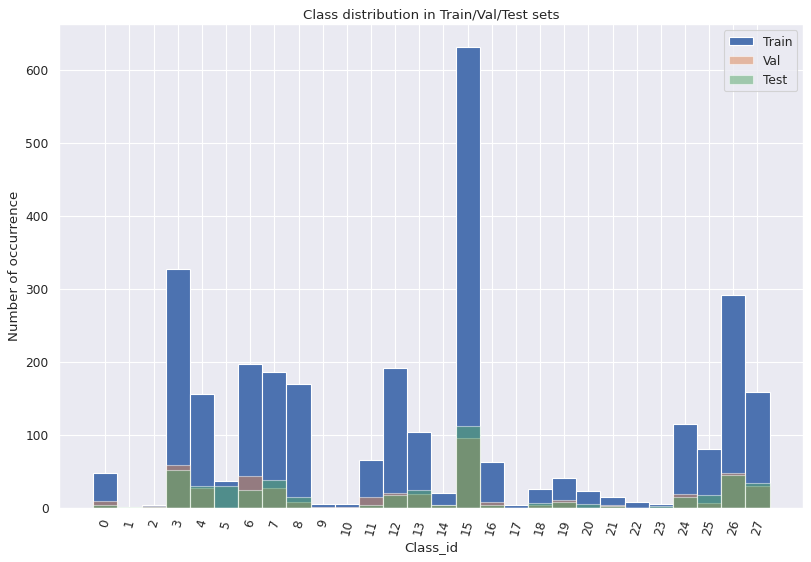

In [42]:
# Visual check of train-test split

def list_add(list1, list2): return [sum(x) for x in zip(list1, list2)]
def vis(img_id_list):
  vis=[0]*nr_class
  for i in img_id_list:
    X = open('./TACO/labels/'+str(i)+'.txt','r')
    lines = X.readlines()
    classes = [int(line.split()[0]) for line in lines]
    x_ = pd.DataFrame([Counter(classes)],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    vis=list_add(vis,x_)
  return vis

from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)

plt.bar([*range(nr_class)],vis(train_ids), width = 1, label = 'Train')
plt.bar([*range(nr_class)],vis(val_ids), width = 1, label = 'Val',alpha = 0.5)
plt.bar([*range(nr_class)],vis(test_ids), width = 1, label = 'Test',alpha = 0.5)

plt.xticks([*range(nr_class)],rotation = 75)
plt.xlabel("Class_id")
plt.ylabel("Number of occurrence")
plt.title("Class distribution in Train/Val/Test sets")
plt.legend()
plt.show()

In [43]:
%%capture

def move_helper(ids, desti):
  for id in ids:
    img_name = os.path.join( './TACO/images', str(id)+'.jpg' )
    lbl_name = os.path.join( './TACO/labels', str(id)+'.txt' )
    print(img_name)
    if os.path.isfile(img_name):
        shutil.copy( img_name, './TACO/images/'+desti)
        shutil.copy( lbl_name, './TACO/labels/'+desti)
    else :
        print('file does not exist', img_name)

!mkdir TACO/images/{train,val,test}
!mkdir TACO/labels/{train,val,test}

move_helper(test_ids,'test')
move_helper(train_ids,'train')
move_helper(val_ids,'val')


In [44]:
# %%bash
# mkdir ./datasets
# mv yoloTACO ./datasets/

In [45]:
#@title yml

if reduced == True:

  with open('/content/yolov5/data/TACO.yaml', mode='w') as fp:
    lines = '''path: ../TACO  # dataset root dir
train: images/train  # train images 
val: images/val  # val images 
test: images/test # test images (optional)

# Classes
names:
  0: Aluminium foil
  1: Battery
  2: Blister pack
  3: Bottle
  4: Bottle cap
  5: Broken glass
  6: Can
  7: Carton
  8: Cup
  9: Food waste
  10: Glass jar
  11: Lid
  12: Other plastic
  13: Paper
  14: Paper bag
  15: Plastic bag & wrapper
  16: Plastic container
  17: Plastic glooves
  18: Plastic utensils
  19: Pop tab
  20: Rope & strings
  21: Scrap metal
  22: Shoe
  23: Squeezable tube
  24: Straw
  25: Styrofoam piece
  26: Unlabeled litter
  27: Cigarette'''
    fp.writelines(lines)

else: 
  with open('/content/yolov5/data/TACO.yaml', mode='w') as fp:
    lines = '''path: ../TACO  # dataset root dir
train: images/train  # train images (relative to 'path') 128 images
val: images/val  # val images (relative to 'path') 128 images
test: images/test # test images (optional)

# Classes
names:
  0: Aluminium foil
  1: Battery
  2: Aluminium blister pack
  3: Carded blister pack
  4: Other plastic bottle
  5: Clear plastic bottle
  6: Glass bottle
  7: Plastic bottle cap
  8: Metal bottle cap
  9: Broken glass
  10: Food Can
  11: Aerosol
  12: Drink can
  13: Toilet tube
  14: Other carton
  15: Egg carton
  16: Drink carton
  17: Corrugated carton
  18: Meal carton
  19: Pizza box
  20: Paper cup
  21: Disposable plastic cup
  22: Foam cup
  23: Glass cup
  24: Other plastic cup
  25: Food waste
  26: Glass jar
  27: Plastic lid
  28: Metal lid
  29: Other plastic
  30: Magazine paper
  31: Tissues
  32: Wrapping paper
  33: Normal paper
  34: Paper bag
  35: Plastified paper bag
  36: Plastic film
  37: Six pack rings
  38: Garbage bag
  39: Other plastic wrapper
  40: Single-use carrier bag
  41: Polypropylene bag
  42: Crisp packet
  43: Spread tub
  44: Tupperware
  45: Disposable food container
  46: Foam food container
  47: Other plastic container
  48: Plastic glooves
  49: Plastic utensils
  50: Pop tab
  51: Rope & strings
  52: Scrap metal
  53: Shoe
  54: Squeezable tube
  55: Plastic straw
  56: Paper straw
  57: Styrofoam piece
  58: Unlabeled litter
  59: Cigarette'''
    fp.writelines(lines)

# 1. Evaluate

## 1.1 detect with torch framework


In [50]:
%%capture
%rm -rf /content/yolov5/runs/predict-seg/*
!python /content/yolov5/segment/predict.py \
--weights /content/weights.pt \
--source /content/TACO/images/test \
--save-txt

In [52]:
def pred_getter(img_id):
  img = base_imgs[img_id]
  img_height = img['height']
  img_width = img['width']
  
  pred_path = '/content/yolov5/runs/predict-seg/exp/labels/'
  X = open(pred_path+str(img_id)+'.txt','r')

  lines = X.readlines()
  lines = [i.replace('\n','') for i in lines]
  lines = [i.split(' ') for i in lines]

  bboxes = []
  for i in lines:
    cache,x,y = [],[],[]

    for j in i:
      cache.append(float(j))

    for id,i in enumerate(cache[1:]):
      if id%2==0: x.append(i)
      else: y.append(i)

    # cen_x,cen_y,width,height  

    bbox = [int(cache[0]), (max(x)+min(x))/2,(max(y)+min(y))/2,(max(x)-min(x)),(max(y)-min(y))]
    bboxes.append(bbox)

  cache = pd.DataFrame(bboxes,columns = ['class','xcenter','ycenter','width','height'])

  cache["xcenter"] = img_width * cache["xcenter"]
  cache["ycenter"] = img_height * cache["ycenter"]
  cache["width"] = img_width * cache["width"]
  cache["height"] = img_height * cache["height"]

  cache = cache.assign(confidence = ['n/a']*cache.shape[0])
  cache = cache.assign(class_name = [number_superid[i] for i in cache['class'].tolist()])
  cache = cache.reindex(columns=['xcenter','ycenter','width','height','confidence','class','class_name'])
  cache = cache.assign(image_id = [img_id]*cache.shape[0])
  return cache

def truth_getter(img_id):

  img = base_imgs[img_id]
  img_height = img['height']
  img_width = img['width']

  cache = pd.read_csv('./TACO/labels/'+str(img_id)+'.txt',header=None,
                      names = ['class','xcenter','ycenter','width','height'],delimiter=' ')
  cache["xcenter"] = img_width * cache["xcenter"]
  cache["ycenter"] = img_height * cache["ycenter"]
  cache["width"] = img_width * cache["width"]
  cache["height"] = img_height * cache["height"]

  cache = cache.assign(confidence = [1]*cache.shape[0])
  cache = cache.assign(class_name = [number_superid[i] for i in cache['class'].tolist()])
  cache = cache.reindex(columns=['xcenter','ycenter','width','height','confidence','class','class_name'])
  cache = cache.assign(image_id = [img_id]*cache.shape[0])
  # cache = cache.assign(img_width = [width]*cache.shape[0])
  # cache = cache.assign(img_height = [height]*cache.shape[0])

  return cache


In [55]:
pred_pd = []
for i in test_ids:
  try: pred_pd.append(pred_getter(i))
  except: pred_pd.append(pd.DataFrame(columns=['xcenter','ycenter','width','height','confidence','class','class_name'] ))

truth_pd=[]
for i in test_ids:
  truth_pd.append(truth_getter(i))

## 1.2 example prediction and truth

In [56]:
pred_pd[:2] 
# predictions for first two images
# there will be a list of two dataframes

[      xcenter     ycenter      width       height confidence  class  \
 0  690.048446  997.282109  355.43125  1123.931823        n/a      6   
 
   class_name  image_id  
 0        Can         6  ,
        xcenter      ycenter       width       height confidence  class  \
 0  1415.154144  1071.096875  409.865568   925.403108        n/a      6   
 1  1042.111155  1055.086715  342.621486   880.573429        n/a      6   
 2   433.715928   707.660414  406.665030  1389.704172        n/a      3   
 3  1788.197133   510.732035  195.327072    99.264071        n/a      4   
 4   747.519253  1000.651554  317.006937   951.018750        n/a      3   
 5  1759.377948  1029.470304  470.704476  1008.656250        n/a      3   
 
    class_name  image_id  
 0         Can        12  
 1         Can        12  
 2      Bottle        12  
 3  Bottle cap        12  
 4      Bottle        12  
 5      Bottle        12  ]

In [57]:
truth_pd[2] 

,xcenter,ycenter,width,height,confidence,class,class_name,image_id
0,775.499498,934.99968,713.000467,1854.000768,1,3,Bottle,14


In [58]:
pred_pd[2]

,xcenter,ycenter,width,height,confidence,class,class_name,image_id
0,1115.925786,2041.161550,80.051571,9.607761,n/a,4,Bottle cap,14
1,773.303125,931.723329,701.256250,1863.446658,n/a,14,Paper bag,14


# 2. Accuracy evaluation

Usually, `Object Detection` tasks are measured by mAP, which is also the default metrics YoloV5 uses. You can also check Yolo's Precision and Recall metrics. 

However, if an `accuracy` metric is specifically needed, the following codes will do it.

For each object with a truth bounding box in each image, if there is a prediction bounding box that has an IOU > threshold with that truth bounding box, it is counted as `detected`.

For overall model `accuracy`, we count total number of `detected` of all images over total number of `predictions` of all images.

**Definition of `Accuracy`:**

$$\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}$$

A comparison of `Accuracy, Precision, Recall`:
$$
\text{Accuracy} = \frac{TP+TN}{TP+TN+FP+FN}
$$

$$\text{Precision} = \frac{TP}{TP+FP}
$$

$$\text{Recall} = \frac{TP}{TP+FN}
$$
CC: https://developers.google.com/machine-learning/crash-course/classification/accuracy

In [59]:
def bbox_iou(box1, box2, eps=1e-7):
  """
  CITATION: adapted from YOLOV5 utils, author, cr: ultralytics
  Returns Intersection over Union (IoU) of box1(1,4) to box2(n,4)
  Get the coordinates of bounding boxes, transform from xywh to xyxy
  """
  (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, 1), box2.chunk(4, 1)
  w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
  b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
  b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_

  inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
          (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)
  union = w1 * h1 + w2 * h2 - inter + eps
  return inter / union  # return IoU
  
def each_pic(pred_df,truth_df,iou_th,must_class):
  """
  returns number of objects (truth) and number of detection
  e.g. if there are 5 pieces of trash in an image and we predicted 2, it will return 5,2
  """
  pred_df_ = pred_df.assign(matched=[0]*pred_df.shape[0])
  nr_preds = pred_df.shape[0]
  nr_dets = 0
  for i in truth_df.iterrows():
    tbox_tensor = torch.tensor([i[1].tolist()[:4]])
    tlabel = i[1].tolist()[5]
    
    row_counter=0
    for j in pred_df_.iterrows():
      pbox_tensor = torch.tensor([j[1].tolist()[:4]])
      plabel = j[1].tolist()[5]
      matched = j[1].tolist()[-1]
      if must_class==True: # if the detection has to assign a correct class name. 
        if bbox_iou(tbox_tensor,pbox_tensor)>iou_th and matched==0 and tlabel==plabel:
          nr_dets+=1
          pred_df_.iat[row_counter,-1]=1 # mark matched bbox, so one prediction bbox wont be counted as "detected" for two different objects
          continue
      else: 
        if bbox_iou(tbox_tensor,pbox_tensor)>iou_th and matched==0:
          nr_dets+=1
          pred_df_.iat[row_counter,-1]=1
          continue
      row_counter+=1
  return nr_preds,nr_dets

def get_accuracy(pred,truth,iou_th=0.5,must_class=False):
  """
  pred: prediction list of dataframe
  truth: truth list of dataframe
  iou_th IOU threshold you define suitable
  must_class: controls whether the category need to be predicted correctly
              when set to false, only consider whether predicted bbox bounded objects correctly, 
              without considering if the correct class is identified
  """
  preds,dets=0,0
  for i in tqdm(range(len(truth))):
    p,d=each_pic(pred_pd[i],truth_pd[i],iou_th,must_class)
    preds+=p
    dets+=d
  return np.round(dets/preds,6)

## 2.1 Get Accuracy

In [60]:
accuracy = get_accuracy(pred_pd,truth_pd,iou_th=0.5,must_class=True)
print('\nOur trained model has an accuracy of: '+str(accuracy*100)+'%')

100%|██████████| 194/194 [00:00<00:00, 270.59it/s]


Our trained model has an accuracy of: 36.887%


**Box-Accuracy**

Some detection tasks care only about "having a bounding box over the target object," they do not care about if the model then label the object with a correct class. If you want such accuracy, it can be obtained by setting `must_class` to `False`. 

Below is an example:

In [61]:
accuracy = get_accuracy(pred_pd,truth_pd,iou_th=0.5,must_class=False)
print('\nOur trained model has an accuracy of: '+str(accuracy*100)+'%')

100%|██████████| 194/194 [00:00<00:00, 285.81it/s]


Our trained model has an accuracy of: 68.2303%


In [62]:
# from google.colab import runtime
# runtime.unassign()